<a href="https://colab.research.google.com/github/davidserra9/TFGTest/blob/main/NNClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction


In [1]:
# general imports
import json
import numpy as np
import os
from os import walk
import time
import h5py
import cv2
from google.colab import drive
import matplotlib.pyplot as plt

In [2]:
# mount the google drive folder to access to all the files in there
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Add the folder called utils (and utils/pyimagesearch) that has all the cusotms
# modueles in .py files

# Some of the functions defined in those files will be used later

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/TFG/utils')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/TFG/utils/pyimagesearch')

In [4]:
# PATHS of different files and folders of the project

# Project Root folder
PROJECT_ROOT = '/content/drive/My Drive/Colab Notebooks/TFG'

# Folder of the HDF5 (videos) files
HDF5_FOLDER = PROJECT_ROOT + "/HDF5 files/"

# Folder of the final labeled sequences
JSON_FOLDER = PROJECT_ROOT + "/data/characteristics_tracks/"

Look for all the sequences which are useble. In other words, look for all the sequnces which have linked a HDF5 file with a JSON file and vice versa.

In [5]:
# All the files in .h5 and .json
all_HDF5 = []
all_labeled = []

# The .h5 files which do not have assigned a .json file and viceversa
missing_HDF5 = []
missing_labeled = []

# Adquire all the HDF5 names
for (dirpathHDF5, dirnamesHDF5, filenamesHDF5) in walk(HDF5_FOLDER):
    for fileHDF5 in filenamesHDF5:
        if fileHDF5.endswith('.h5'):
            all_HDF5.append(fileHDF5[:-3])

# Adquire all the .json names
for (dirpathJSON, dirnamesJSON, filenamesJSON) in walk(JSON_FOLDER):
    for fileJSON in filenamesJSON:
        if fileJSON.endswith('.h5.json'):
            all_labeled.append(fileJSON[:-8])

# Detect which files are missing
for filename in all_HDF5:
    if not filename in all_labeled:
        missing_labeled.append(filename)
    
for filename in all_labeled:
    if not filename in all_HDF5:
        missing_HDF5.append(filename)

# Display
if len(missing_HDF5)==0 and len(missing_labeled)==0:
    print('All the files have assigned a JSON file and a HDF5 file.')

elif len(missing_labeled)>0 and len(missing_HDF5)==0:
    print('All the JSON files have assigned a HDF5 file.')
    print('The following HDF5 files do not have assigned a JSON file:')
    for filename in missing_labeled:
        print('\t{}'.format(filename))

elif len(missing_labeled)==0 and len(missing_HDF5)>0:
    print('All the HDF5 files have assigned a JSON file.')
    print('The following JSON files do not have assigned a HDF5 file:')
    for filename in missing_HDF5:
        print('\t{}'.format(filename))

else:
    print('The following HDF5 files do not have assigned a JSON file:')
    for filename in missing_labeled:
        print('\t{}'.format(filename))
    print('The following JSON files do not have assigned a HDF5 file:')
    for filename in missing_HDF5:
        print('\t{}'.format(filename))

The following HDF5 files do not have assigned a JSON file:
	20180918.045_AEQ50
The following JSON files do not have assigned a HDF5 file:
	20180906.036_AEQ10
	20180906.036_AEQ51


So we conclude that the usable files are:

In [6]:
usable_sequences = ['20171207.039_AEQ11', '20171207.043_AEQ11',
                    '20180918.036_AEQ50', '20180918.038_AEQ50',
                    '20180918.040_AEQ50', '20180919.007_AEQ40',
                    '20180920.034_AEQ11', '20181002.028_AEQ20',
                    '20181004.038_AEQ10', '20181004.038_AEQ20',
                    '20181004.038_AEQ40', '20181004.046_AEQ20',
                    '20181004.046_AEQ40', '20181004.046_AEQ50']

To facilitate the visualization of the filenames, the following to function link every file name to a number and vice versa:

In [7]:
def seq2num(seq):
    """
    Link a string sequence filename to a number
    - seq:      string with the filename
    - return:   int
    """
    num = -1
    if '20171207.039_AEQ11' in seq:
        num = 1
    elif '20171207.043_AEQ11' in seq:
        num = 2
    elif '20180918.036_AEQ50' in seq:
        num = 3
    elif '20180918.038_AEQ50' in seq:
        num = 4
    elif '20180918.040_AEQ50' in seq:
        num = 5
    elif '20180919.007_AEQ40' in seq:
        num = 6
    elif '20180920.034_AEQ11' in seq:
        num = 7
    elif '20181002.028_AEQ20' in seq:
        num = 8
    elif '20181004.038_AEQ10' in seq:
        num = 9
    elif '20181004.038_AEQ20' in seq:
        num = 10
    elif '20181004.038_AEQ40' in seq:
        num = 11
    elif '20181004.046_AEQ20' in seq:
        num = 12
    elif '20181004.046_AEQ40' in seq:
        num = 13
    elif '20181004.046_AEQ50' in seq:
        num = 14
        
    return num

In [8]:
def num2seq(num):
    """
    Link every number between 1 and 14 to a sequence name
    - num:      int
    - return:   string with the linked filename
    """
    seq = ''
    if num == 1:
        seq = '20171207.039_AEQ11'
    elif num == 2:
        seq = '20171207.043_AEQ11'
    elif num == 3:
        seq ='20180918.036_AEQ50'
    elif num == 4:
        seq = '20180918.038_AEQ50'
    elif num == 5:
        seq = '20180918.040_AEQ50'
    elif num == 6:
        seq = '20180919.007_AEQ40'
    elif num == 7:
        seq = '20180920.034_AEQ11'
    elif num == 8:
        seq = '20181002.028_AEQ20'
    elif num == 9:
        seq = '20181004.038_AEQ10'
    elif num == 10:
        seq = '20181004.038_AEQ20'
    elif num == 11:
        seq = '20181004.038_AEQ40'
    elif num == 12:
        seq = '20181004.046_AEQ20'
    elif num == 13:
        seq = '20181004.046_AEQ40'
    elif num == 14:
        seq = '20181004.046_AEQ50'
    
    return seq 

Load the data file which contains all the possibilities of the file names. It is useful to avoid any undesirable external file.

In [9]:
# Load the data.json file

# cusotm imports for this block
from JSONLoader import loadData

path_data = PROJECT_ROOT + '/data.json'
data = loadData(path_data)

Now, let's count all the detections we have. It is done both for frame-by-frame detections and for track detections.

In [10]:
# cusotm imports for this block
from JSONLoader import loadData

# Counters of all the TOTAL FRAMES with NoHotSpots, HotSpots and Anomalies
nNoHotSpot_fr = 0  # detection[6] == 0
nHotSpot_fr = 0    # detection[6] == 1
nAnomaly_fr = 0    # detection[6] == 2

# Counters of all the TOTAL TRACKS being NoHotSpots, HotSpots and Anomalies
nNoHotSpot_tr = 0  # detection[6] == 0
nHotSpot_tr = 0    # detection[6] == 1
nAnomaly_tr = 0    # detection[6] == 2

for (dirpath, dirnames, filenames) in walk(HDF5_FOLDER):
    for file in filenames:
        if file.endswith('.h5') and file[:-3] in usable_sequences:
            filename, _= os.path.splitext(os.path.basename(file))

            aux = filename.split('_')
            xp = aux[0]
            port =aux[1]

            # FRAME-BY-FRAME
            # Counter of frames with NoHotSpots of the actual file
            nNoHotSpot_fr_i = 0

            # Counter of frames with HotSpots of the actual file
            nHotSpot_fr_i = 0

            # Counter of frames with Anomalies of the actual file
            nAnomaly_fr_i = 0

            # TRACKS
            # Counter of tracks which are NoHotSpots of the actual file
            nNoHotSpot_tr_i = 0

            # Counter of tracks which are HotSpots of the actual file
            nHotSpot_tr_i = 0

            # Counter of tracks which are Anomalies of the actual file
            nAnomaly_tr_i = 0

            # Actual trackID
            actualTrackID = -1  # detection[1]
           
            if [xp, port] in data:
                nNoHotSpot_fr_i = 0
                nHotSpot_fr_i = 0
                nAnomaly_fr_i = 0
                nNoHotSpot_tr_i = 0
                nHotSpot_tr_i = 0
                nAnomaly_tr_i = 0

                try:
                    filename = JSON_FOLDER + file + '.json'
                    detections = loadData(filename)

                    # FRAME-BY-FRAME
                    for detection in detections:
                        if detection[6] == 0:
                            nNoHotSpot_fr_i = nNoHotSpot_fr_i + 1
                        elif detection[6] == 1:
                            nHotSpot_fr_i = nHotSpot_fr_i + 1
                        elif detection[6] == 2:
                            nAnomaly_fr_i = nAnomaly_fr_i + 1

                    # TRACKS
                    for detection in detections:
                        if actualTrackID != detection[1]:                           
                            if detection[6] == 0:
                                nNoHotSpot_tr_i = nNoHotSpot_tr_i + 1
                            elif detection[6] == 1:
                                nHotSpot_tr_i = nHotSpot_tr_i + 1
                            elif detection[6] == 2:
                                nAnomaly_tr_i = nAnomaly_tr_i + 1
                        
                        actualTrackID = detection[1]
            
                    print('{} ({})'.format(file, seq2num(file)))

                    print('\tFRAME-BY-FRAME:')
                    print('\tNumber of NoHotSpots: {}'.format(nNoHotSpot_fr_i))
                    print('\tNumber of HotSpots: {}'.format(nHotSpot_fr_i))
                    print('\tNumber of Anomalies: {}'.format(nAnomaly_fr_i))

                    print('\tTRACK:')
                    print('\tNumber of NoHotSpots: {}'.format(nNoHotSpot_tr_i))
                    print('\tNumber of HotSpots: {}'.format(nHotSpot_tr_i))
                    print('\tNumber of Anomalies: {}'.format(nAnomaly_tr_i))

                    nNoHotSpot_fr = nNoHotSpot_fr + nNoHotSpot_fr_i
                    nHotSpot_fr = nHotSpot_fr + nHotSpot_fr_i
                    nAnomaly_fr = nAnomaly_fr + nAnomaly_fr_i

                    nNoHotSpot_tr = nNoHotSpot_tr + nNoHotSpot_tr_i
                    nHotSpot_tr = nHotSpot_tr + nHotSpot_tr_i
                    nAnomaly_tr = nAnomaly_tr + nAnomaly_tr_i

                except Exception as e:
                    print('Error opening file')
                    print(e)

print("==============================================================")
print("==============================================================")
print('Number of the TOTAL FRAME detections as NoHotSpots: {}'.format(nNoHotSpot_fr))
print('Number of the TOTAL FRAME detections as HotSpots: {}'.format(nHotSpot_fr))
print('Number of the TOTAL FRAME detections as Anomalies: {}'.format(nAnomaly_fr))
print("--------------------------------------------------------------")
print('Number of the TOTAL TRACKS as NoHotSpots: {}'.format(nNoHotSpot_tr))
print('Number of the TOTAL TRACKS detections as HotSpots: {}'.format(nHotSpot_tr))
print('Number of the TOTAL TRAKCS detections as Anomalies: {}'.format(nAnomaly_tr))
print("==============================================================")
print('Number of the TOTAL FRAME DETECTIONS: {}'.format(nNoHotSpot_fr+nHotSpot_fr+nAnomaly_fr))
print("--------------------------------------------------------------")
print('Number of the TOTAL TRACKS DETECTED: {}'.format(nNoHotSpot_tr+nHotSpot_tr+nAnomaly_tr))

20171207.039_AEQ11.h5 (1)
	FRAME-BY-FRAME:
	Number of NoHotSpots: 5473
	Number of HotSpots: 0
	Number of Anomalies: 191
	TRACK:
	Number of NoHotSpots: 49
	Number of HotSpots: 0
	Number of Anomalies: 3
20171207.043_AEQ11.h5 (2)
	FRAME-BY-FRAME:
	Number of NoHotSpots: 7887
	Number of HotSpots: 0
	Number of Anomalies: 279
	TRACK:
	Number of NoHotSpots: 74
	Number of HotSpots: 0
	Number of Anomalies: 3
20180918.036_AEQ50.h5 (3)
	FRAME-BY-FRAME:
	Number of NoHotSpots: 8592
	Number of HotSpots: 673
	Number of Anomalies: 877
	TRACK:
	Number of NoHotSpots: 56
	Number of HotSpots: 3
	Number of Anomalies: 8
20180918.038_AEQ50.h5 (4)
	FRAME-BY-FRAME:
	Number of NoHotSpots: 7325
	Number of HotSpots: 433
	Number of Anomalies: 829
	TRACK:
	Number of NoHotSpots: 62
	Number of HotSpots: 2
	Number of Anomalies: 6
20180918.040_AEQ50.h5 (5)
	FRAME-BY-FRAME:
	Number of NoHotSpots: 6702
	Number of HotSpots: 255
	Number of Anomalies: 398
	TRACK:
	Number of NoHotSpots: 83
	Number of HotSpots: 1
	Number of An

BBox length study:


*   Histogram with the maximum side length of the Bounding Boxes
*   2D-Histogram with the maximum side length of the Bounding Boxes and the form factor (min_side_len/max_side_len)



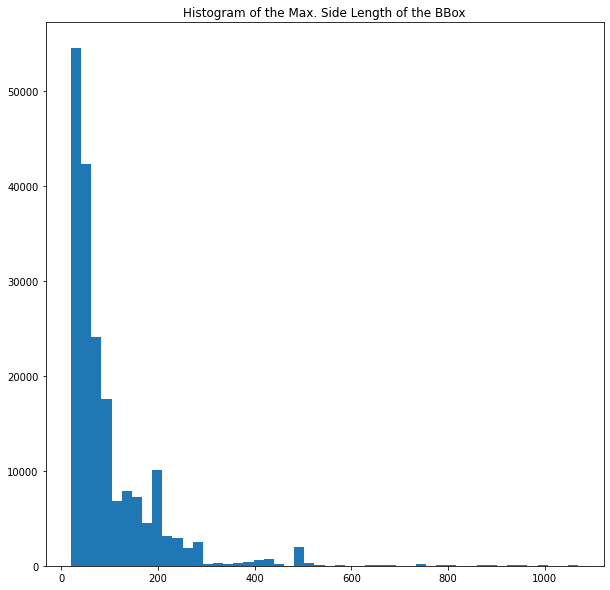

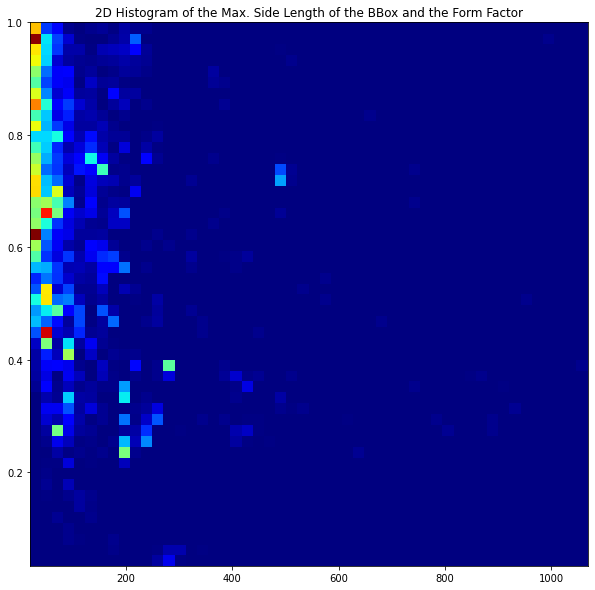

In [11]:
max_len = []
form_factor = []
for (dirpath, dirnames, filenames) in walk(HDF5_FOLDER):
    for file in filenames:
        if file.endswith('.h5') and file[:-3] in usable_sequences:
            filename, _= os.path.splitext(os.path.basename(file))

            aux = filename.split('_')
            xp = aux[0]
            port = aux[1]

            if [xp, port] in data:

                try:
                    filename = JSON_FOLDER + file + '.json'
                    detections = loadData(filename)

                    for detection in detections:
                        xdif = detection[4] - detection[2]
                        ydif = detection[5] - detection[3]
                        max_len.append(max(xdif, ydif))
                        if xdif < ydif:
                            form_factor.append(xdif/ydif)
                        else:
                            form_factor.append(ydif/xdif)
                    
                except Exception as e:
                    print('Error opening file')
                    print(e)

plt.figure(figsize=(10,10))
plt.title('Histogram of the Max. Side Length of the BBox')                    
_ = plt.hist(max_len, bins=50)
plt.show()

plt.figure(figsize=(10,10))
plt.title('2D Histogram of the Max. Side Length of the BBox and the Form Factor')  
_ = plt.hist2d(max_len, form_factor, bins=50, cmap=plt.cm.jet)
plt.show()

Seeing the above histogram we can conclude that almost all the BBoxes have a maximum side length of at most 250 pixels. We can also see that almost all the detections have a reduced form factor. In other words, both sides are quite similar.

In [12]:
MAX_SQUARE_LEN = 224

counter = 0
total_counter = 0
for (dirpath, dirnames, filenames) in walk(HDF5_FOLDER):
    for file in filenames:
        if file.endswith('.h5') and file[:-3] in usable_sequences:
            filename, _= os.path.splitext(os.path.basename(file))

            aux = filename.split('_')
            xp = aux[0]
            port = aux[1]

            if [xp, port] in data:

                try:
                    filename = JSON_FOLDER + file + '.json'
                    detections = loadData(filename)

                    for detection in detections:
                        total_counter = total_counter + 1
                        xdif = detection[4] - detection[2]
                        ydif = detection[5] - detection[3]
                        if xdif<MAX_SQUARE_LEN and ydif<MAX_SQUARE_LEN:
                            counter = counter + 1
                   
                except Exception as e:
                    print('Error opening file')
                    print(e)

print('The {:.2f}% of the BBoxes are completely inside of a {} pixels square'.format((counter/total_counter)*100,MAX_SQUARE_LEN))

The 92.32% of the BBoxes are completely inside of a 224 pixels square


Function which is capable of loading multiple hdf5Loader and store the hdf5Loader obejects in a list

In [13]:
# INITIALIZE ALL THE HDF5LOADERS
from hdf5Loader import hdf5Loader

def hdf5Initializer(hdf5Names):
    """
    Function to load all the sequence loaders
    - hdf5Names:    list with all the filenames
    - return:       list with all de hdf5Loaders
    """
    loaders = []
    for n in hdf5Names:
        loaders.append(hdf5Loader(HDF5_FOLDER + n + '.h5'))

    return loaders

Function which is capable of loading the detections of all the files that are passed as parameters. The function has 2 features:


*   trackLevel = False *(default)*: the function loads all the detections stored in the associated json file
*   trackLevel = True: the function loads only one detections per trackID. The detection and image in charge of representing the trackID is the one on the centre of all the frames.



In [14]:
# INITIALIZE ALL THE DETECTIONS AS:
# [seqNum, frameNum, trackID, xmin, ymin, xmax, ymax, label]
from JSONLoader import loadData

def detectionLoader(jsonNamesList, trackLevel=False):
    """
    Function to load all the detections which are in .json files
    - jsonNamesList: list with all the filenames
    - trackLevel:
        if False:   load all the detections even though there are more than one
                    for a track
        if True:    load only one detections for track. Take as the thumbnail 
                    for the detection a frame of the middle

    - return:   detections: list with all the detections
                            [seqNum, frameNum, trackID, BBox]
                labels:     list with all the labels of the previous list of
                            detections
    """
    detections = []
    labels = []

    # FRAME BY FRAME DETECTIONS
    # Add all the detectons of the file
    if not trackLevel:
        for seq in jsonNamesList:
            detections_i = loadData(JSON_FOLDER + seq + '.h5.json')
            seqNum = seq2num(seq)
            for d in detections_i:
                detections.append([seqNum, d[0], d[1], d[2], d[3], d[4], d[5]])
                labels.append(d[6])
    
    # TRACK DETECTIONS
    # Add one detection per track (the middle one)
    else:
        for seq in jsonNamesList:

            # Detections of each sequence of the list
            detections_i = loadData(JSON_FOLDER + seq + '.h5.json')
            # Number of the sequence
            seqNum = seq2num(seq)

            # List with all the detections with the same trackID            
            sameTrackID_detections = []
            trackID = 0

            for d in detections_i:
                if d[1] == trackID:
                    sameTrackID_detections.append(d)
                else:
                    detections.append([seqNum,
                                    sameTrackID_detections[(round(len(sameTrackID_detections)/2))][0],
                                    sameTrackID_detections[(round(len(sameTrackID_detections)/2))][1],
                                    sameTrackID_detections[(round(len(sameTrackID_detections)/2))][2],
                                    sameTrackID_detections[(round(len(sameTrackID_detections)/2))][3],
                                    sameTrackID_detections[(round(len(sameTrackID_detections)/2))][4],
                                    sameTrackID_detections[(round(len(sameTrackID_detections)/2))][5]])
                    
                    labels.append(sameTrackID_detections[(round(len(sameTrackID_detections)/2))][6])
                    trackID = d[1]
                    sameTrackID_detections = []
                    sameTrackID_detections.append(d)
            
            # Add the final track detection
            detections.append([seqNum,
                            sameTrackID_detections[(round(len(sameTrackID_detections)/2))][0],
                            sameTrackID_detections[(round(len(sameTrackID_detections)/2))][1],
                            sameTrackID_detections[(round(len(sameTrackID_detections)/2))][2],
                            sameTrackID_detections[(round(len(sameTrackID_detections)/2))][3],
                            sameTrackID_detections[(round(len(sameTrackID_detections)/2))][4],
                            sameTrackID_detections[(round(len(sameTrackID_detections)/2))][5]])
            
            labels.append(sameTrackID_detections[(round(len(sameTrackID_detections)/2))][6])

    return detections, labels

Function which crops the detection into a square of **MAX_SQUARE_LEN x MAX_SQUARE_LEN**

First of all, the function looks for the side of the detection with the max length and crops it with a square of that length.
Then, the function resizes the square into another square with the desirable dimensions.

In [47]:
def crop_detection(image, detection):
    """
    Function to crop the detection in a square of the max length side and then
    resize it to a square MAX_SQUARE_LEN x MAX_SQUARE_LEN"
    - image:        np.ndarray(1024, 1280)
    - detection:    [xmin, ymin, xmax, ymax]
    - return:       np.ndarray(MAX_SQUARE_LEN, MAX_SQUARE_LEN)
    """
    
    # Find the min point of the square detection
    x_diff = detection[2] - detection[0]
    y_diff = detection[3] - detection[1]
    max_len = max(x_diff, y_diff)
    xmin = ((x_diff - max_len) / 2) + detection[0]
    ymin = ((y_diff - max_len) / 2) + detection[1]

    # If image limits exceeded
    if xmin < 0:
        xmin = 0
    if ymin < 0:
        ymin = 0
    if (xmin + max_len) > image.shape[1]:
        xmin = image.shape[1] - max_len
    if (ymin + max_len) > image.shape[0]:
        ymin = image.shape[0] - max_len

    xmin = int(xmin)
    ymin = int(ymin)
    max_len = int(max_len)
    # Crop and resize the image
    crop_image = image[ymin:(ymin+max_len), xmin:(xmin+max_len)]
    resized_image = cv2.resize(crop_image, (MAX_SQUARE_LEN, MAX_SQUARE_LEN), interpolation=cv2.INTER_NEAREST)
    
    return resized_image


We have a total number of 951 tracks with:

*   NoHotSpots: 873
*   HotSpots: 41
*   Anomalies: 37

So, to show how the function **crop_detections(.)** works, in the following block one random detections for each label is going to be shown.

In the first column of the graphs the original image can be seen, whereas in the second column the cropped detection of size MAX_SQUARE_LEN x MAX_SQUARE_LEN is shown. If the original Bounding Box is smaller than the previuos mencioned size the BBox can be seen.

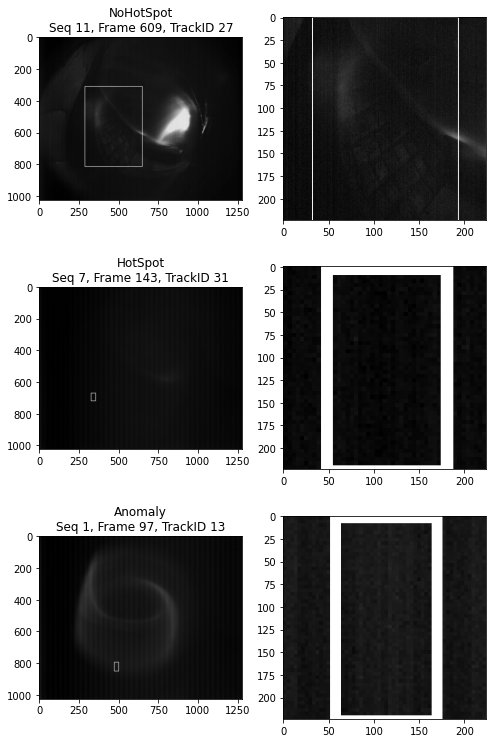

In [51]:
from hdf5Loader import hdf5Loader
from image_tools import plotBBoxes, rescaleImage, showImage
import random

# Get the 6 random files
# Change the seed to get other detections
random.seed(42)
NHS = random.randint(0, 873)
HS = random.randint(0, 41)		
AN = random.randint(0, 37)

# Load all the track detections
detections, labels = detectionLoader(usable_sequences, trackLevel=True)
NHS_counter = 0
HS_counter = 0
AN_counter = 0

# List in which the three detections are stored
# 0: NoHotSpot
# 1: HotSpot
# 2: Anomaly
d3 = [None] * 3

# Obtain the random detections
for (detection, label) in zip(detections, labels):
    if label == 0:
        NHS_counter = NHS_counter + 1
    elif label == 1:
        HS_counter = HS_counter + 1
    elif label == 2:
        AN_counter = AN_counter + 1

    if NHS_counter == NHS:
        d3[0] = detection
    if HS_counter == HS:
        d3[1] = detection
    if AN_counter == AN:
        d3[2] = detection


# Obtain the filenames of the random detections
files2Load = [num2seq(d3[0][0]), num2seq(d3[1][0]), num2seq(d3[2][0])]
# Obtain the hdf5Loaders of the previous sequences
loaders = hdf5Initializer(files2Load)

# 1. Obtain the original images of the sequences
# 2. Rescale the dynamic range to be able to visualize them
# 3. Draw the BBoxes of the detections in the origianl images
OGims = []
for (loader, detection) in zip(loaders, d3):
    im_t = loader.loadImage(detection[0])

    im_t = rescaleImage(im_t)

    detection = [detection[3:7]]
    im_t = plotBBoxes(im_t, detection)

    OGims.append(im_t)

# Obtain the cropped images
cropped_ims = []
for (image, detection) in zip(OGims, d3):
    BBox = detection[3:7]
    cropped_ims.append(crop_detection(image, BBox))

# Plot images
f, axarr = plt.subplots(nrows=3, ncols=2, figsize=(8,13))
titles = ['NoHotSpot\nSeq {}, Frame {}, TrackID {}',
          'HotSpot\nSeq {}, Frame {}, TrackID {}',
          'Anomaly\nSeq {}, Frame {}, TrackID {}']

for i in range(len(cropped_ims)):
        axarr[i,0].imshow(OGims[i])
        axarr[i,1].imshow(cropped_ims[i])
        axarr[i,0].title.set_text(titles[i].format(d3[i][0], d3[i][1], d3[i][2]))


movement study

In [ ]:
for seq in usable_sequences:
    

In [ ]:
import torch
from hdf5Loader import hdf5Loader
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class Dataset(Dataset):
    def __init__(self, loaders, labels, detections, transform=None):
        'Initialization'
        self.loaders = loaders
        self.labels = labels
        self.detections = detections
        self.transform = transform
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.detections)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        seqNum = self.detections[index][0]
        frameNum = self.detections[index][1]
        # Load data and get label
        image = self.loaders[0].loadImage(frameNum)
        BBox = [self.detections[index][2], self.detections[index][3], self.detections[index][4], self.detections[index][5]]
        resized_image = crop_detection(image, BBox)
        y = self.labels[index]
        if self.transform:
            resized_image = self.transform(resized_image)
            y = self.transform(self.labels[index])
        return resized_image, y

140


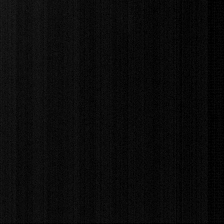

In [ ]:
import torchvision.transforms as transforms
from image_tools import rescaleImage, showImage

usable_sequences = ['20180920.034_AEQ11', '20180918.038_AEQ50']
loaders = hdf5Initializer(usable_sequences)
detections, labels = detectionLoader(usable_sequences, trackLevel=True)
dataset = Dataset(loaders, labels, detections)

print(len(dataset))
im2 = dataset[50][0]
im2 = rescaleImage(im2)
showImage(im2)

In [ ]:
from JSONLoader import loadData
import imageio
import time

def crop_detections(images, detections, fileName):

    print('\tCreating images...')
    # Sizes oof the output images
    images_shape = (MAX_SQUARE_LEN, MAX_SQUARE_LEN)
    counter = 0
    for detection in detections:
        
        if counter%100:
            print('{} done of {}'.format(counter, len(detections)))
        # Create a black image of the desirable dimensions (224 x 224)
        black_image = np.zeros(images_shape, dtype=np.uint16)

        # Create the name of the file that will be stored
        # Label_SeqNumber_frameNumber_trackID
        frameNumber = str(detection[0])
        trackID = str(detection[1])
        seq_number = str(seq2num(fileName))

        if detection[6] == 0:
            image_path = PROJECT_ROOT + '/all_images/NoHotSpots/' + 'NoHotSpot_' + seq_number + '_' + frameNumber + '_' + trackID + '.png'

        elif detection[6] == 1:
            image_path = PROJECT_ROOT + '/all_images/HotSpots/' + 'HotSpot_' + seq_number + '_' + frameNumber + '_' + trackID + '.png'

        elif detection[6] == 2:
            image_path = PROJECT_ROOT + '/all_images/Anomalies/' + 'Anomaly_' + seq_number + '_' + frameNumber + '_' + trackID + '.png'

        # BBox side lengths
        xdif = detection[4] - detection[2]
        ydif = detection[5] - detection[3]

        # If the side are longer than the MAX_SQUARE_LEN crop them
        if xdif > MAX_SQUARE_LEN:
            xdif = MAX_SQUARE_LEN
        
        if ydif > MAX_SQUARE_LEN:
            ydif = MAX_SQUARE_LEN

        # # If the BBox fits inside the MAX_SQUARE_LEN square
        # if xdif <= MAX_SQUARE_LEN and ydif <= MAX_SQUARE_LEN:
        
        xmin = int((detection[4] - detection[2] - xdif)/2)
        ymin = int((detection[5] - detection[3] - ydif)/2)

        crop_image = images[ymin:(ymin+ydif), xmin:(xmin+xdif), detection[0]]
        
        # elif xdif > MAX_SQUARE_LEN and ydif <= MAX_SQUARE_LEN:
        #     xdif = MAX_SQUARE_LEN

        #     crop_image = images[int(detection[3]):int(detection[5]), int(detection[2]):int(detection[4]), detection[0]]

            
        # Find the center
        xmin = int((MAX_SQUARE_LEN - xdif)/2)
        ymin = int((MAX_SQUARE_LEN - ydif)/2)
        black_image[ymin:(ymin+ydif), xmin:(xmin+xdif)]=crop_image

        imageio.imwrite(image_path, black_image)
        counter = counter + 1
# showImage(black_image)
# print(black_image.shape)
# print(type(black_image))
# print(type(black_image[0,0]))
# imageio.imwrite(PROJECT_ROOT + '/prueba1.png', black_image)
# im1 = cv2.imread(PROJECT_ROOT + '/prueba1.png', -cv2.IMREAD_ANYDEPTH)
# print(im1.shape)
# print(type(im1))
# print(type(im1[0][0]))

In [ ]:
import time

ttotal = time.time()

usable_sequences = ['20181004.046_AEQ20']
for sequence in reversed(usable_sequences):
    print(sequence)

    # Load the file
    print('\tLoading all the frames of the sequence')
    f = h5py.File(HDF5_FOLDER + sequence + '.h5', 'r', driver='core')
    tseq = time.time()

    images = f['ROIP']['ROIP1']['ROIP1Data'][()]

    elapsedseq = time.time() - tseq
    print('\tElapsed time loading the frames: {:.2f} seconds'.format(elapsedseq))

    # Load the detections
    detections = loadData(JSON_FOLDER + sequence + '.h5.json')
    print('\tDetections loaded')
    print('\tCropping and creating all the images (to create: {} images)'.format(len(detections)))
    # Create the images
    tcrop = time.time()
    crop_detections(images, detections, sequence)
    elapsedcrop = time.time() - tcrop
    print('\tFinished creating the images. Elapsed time: {:.2f} minutes'.format(elapsedcrop/60))

elapsedtotal = time.time() - ttotal
print('Elapsed time creating all the images: {:.2f}'.format(elapsedtotal/60))

Se han truncado las últimas 5000 líneas del flujo de salida.
18587 done of 23636
18588 done of 23636
18589 done of 23636
18590 done of 23636
18591 done of 23636
18592 done of 23636
18593 done of 23636
18594 done of 23636
18595 done of 23636
18596 done of 23636
18597 done of 23636
18598 done of 23636
18599 done of 23636
18601 done of 23636
18602 done of 23636
18603 done of 23636
18604 done of 23636
18605 done of 23636
18606 done of 23636
18607 done of 23636
18608 done of 23636
18609 done of 23636
18610 done of 23636
18611 done of 23636
18612 done of 23636
18613 done of 23636
18614 done of 23636
18615 done of 23636
18616 done of 23636
18617 done of 23636
18618 done of 23636
18619 done of 23636
18620 done of 23636
18621 done of 23636
18622 done of 23636
18623 done of 23636
18624 done of 23636
18625 done of 23636
18626 done of 23636
18627 done of 23636
18628 done of 23636
18629 done of 23636
18630 done of 23636
18631 done of 23636
18632 done of 23636
18633 done of 23636
18634 done of 23636

Now to show our final dataset, we are going to show 2 cases for each different label (2 cases x 3 labels = 6 final cases)

Obtaining the random detections
Finished obtaining the random detections

Obtaining and processing both the original images and the cropped detections images
Finished obtaining and processing the images.


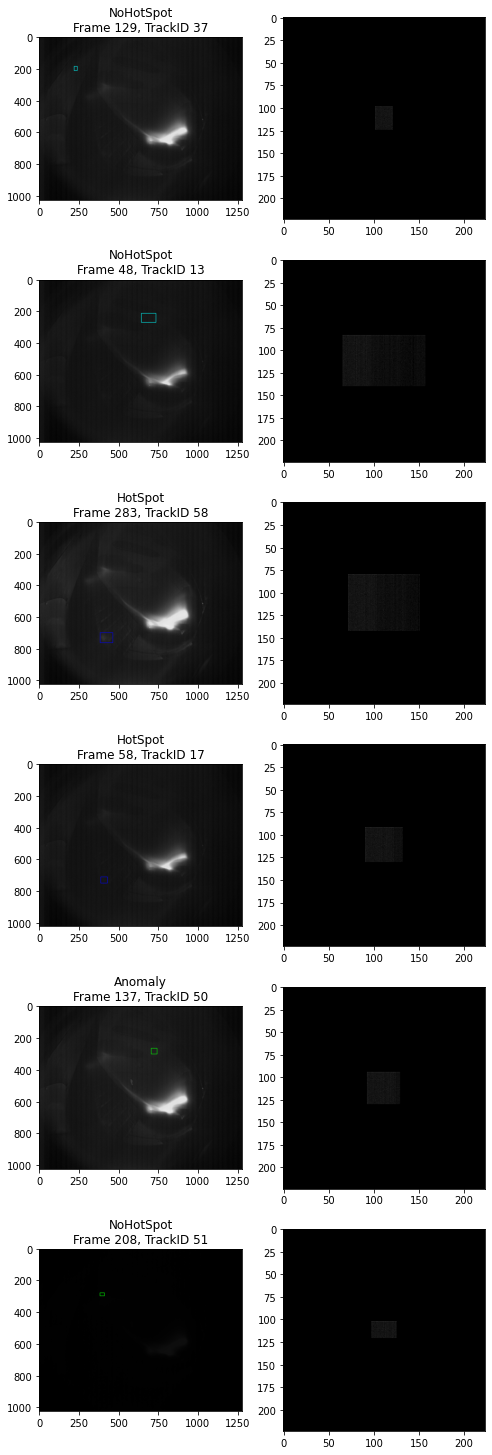

In [ ]:
from JSONLoader import loadData
from image_tools import plotBBoxes
from hdf5Loader import hdf5Loader

detections = loadData(JSON_FOLDER + '20180918.036_AEQ50.h5.json')
seqNum = str(seq2num('20180918.036_AEQ50.h5.json'))

# From one of the previous block we know that this sequence has:
#   Number of NoHotSpots: 8592
#   Number of HotSpots: 673
#   Number of Anomalies: 877

print('Obtaining the random detections')
# Get the 6 random files
random.seed(84)
NHS1 = random.randint(0, 8592)
NHS2 = random.randint(0, 8592)	
HS1 = random.randint(0, 672)	
HS2 = random.randint(0, 672)	
AN1 = random.randint(0, 876)	
AN2 = random.randint(0, 876)	

NHS_counter = 0
HS_counter = 0
AN_counter = 0

for detection in detections:
    if detection[6] == 0:
        NHS_counter = NHS_counter + 1
    elif detection[6] == 1:
        HS_counter = HS_counter + 1
    elif detection[6] == 2:
        AN_counter = AN_counter + 1

    if NHS_counter == NHS1:
        fNumberNHS1 = detection[0]
        trackIDNHS1 = detection[1]
        BBoxNHS1 = [detection[2], detection[3], detection[4], detection[5], 0]
        path_NHS1 = PROJECT_ROOT + '/all_images/NoHotSpots/NoHotSpot_' + seqNum + '_' + str(fNumberNHS1) + '_' + str(trackIDNHS1) + '.png'
    
    if NHS_counter == NHS2:
        fNumberNHS2 = detection[0]
        trackIDNHS2 = detection[1]
        BBoxNHS2 = [detection[2], detection[3], detection[4], detection[5], 0]
        path_NHS2 = PROJECT_ROOT + '/all_images/NoHotSpots/NoHotSpot_' + seqNum + '_' + str(fNumberNHS2) + '_' + str(trackIDNHS2) + '.png'
    
    if HS_counter == HS1:
        fNumberHS1 = detection[0]
        trackIDHS1 = detection[1]
        BBoxHS1 = [detection[2], detection[3], detection[4], detection[5], 1]
        path_HS1 = PROJECT_ROOT + '/all_images/HotSpots/HotSpot_' + seqNum + '_' + str(fNumberHS1) + '_' + str(trackIDHS1) + '.png'

    if HS_counter == HS2:
        fNumberHS2 = detection[0]
        trackIDHS2 = detection[1]
        BBoxHS2 = [detection[2], detection[3], detection[4], detection[5], 1]
        path_HS2 = PROJECT_ROOT + '/all_images/HotSpots/HotSpot_' + seqNum + '_' + str(fNumberHS2) + '_' + str(trackIDHS2) + '.png'

    if AN_counter == AN1:
        fNumberAN1 = detection[0]
        trackIDAN1 = detection[1]
        BBoxAN1 = [detection[2], detection[3], detection[4], detection[5], 2]
        path_AN1 = PROJECT_ROOT + '/all_images/Anomalies/Anomaly_' + seqNum + '_' + str(fNumberAN1) + '_' + str(trackIDAN1) + '.png'

    if AN_counter == AN2:
        fNumberAN2 = detection[0]
        trackIDAN2 = detection[1]
        BBoxAN2 = [detection[2], detection[3], detection[4], detection[5], 2]
        path_AN2 = PROJECT_ROOT + '/all_images/Anomalies/Anomaly_' + seqNum + '_' + str(fNumberAN2) + '_' + str(trackIDAN2) + '.png'

print('Finished obtaining the random detections')
print('\nObtaining and processing both the original images and the cropped detections images')

# Get the frames with hdf5Loader
loader = hdf5Loader(HDF5_FOLDER + '20180918.036_AEQ50.h5')

OG_NHS1 = loader.loadImage(fNumberNHS1)
OG_NHS2 = loader.loadImage(fNumberNHS2)
OG_HS1 = loader.loadImage(fNumberHS1)
OG_HS2 = loader.loadImage(fNumberHS2)
OG_AN1 = loader.loadImage(fNumberAN1)
OG_AN2 = loader.loadImage(fNumberAN2)

OG_NHS1 = rescaleImage(OG_NHS1)
OG_NHS2 = rescaleImage(OG_NHS2)
OG_HS1 = rescaleImage(OG_HS1)
OG_HS2 = rescaleImage(OG_HS2)
OG_AN1 = rescaleImage(OG_AN1)
OG_AN2 = rescaleImage(OG_AN1)

OG_NHS1 = plotBBoxes(OG_NHS1, [BBoxNHS1])
OG_NHS2 = plotBBoxes(OG_NHS2, [BBoxNHS2])
OG_HS1 = plotBBoxes(OG_HS1, [BBoxHS1])
OG_HS2 = plotBBoxes(OG_HS2, [BBoxHS2])
OG_AN1 = plotBBoxes(OG_AN1, [BBoxAN1])
OG_AN2 = plotBBoxes(OG_AN2, [BBoxAN2])

BBox_square_NHS1 = cv2.imread(path_NHS1, -cv2.IMREAD_ANYDEPTH)
BBox_square_NHS2 = cv2.imread(path_NHS2, -cv2.IMREAD_ANYDEPTH)
BBox_square_HS1 = cv2.imread(path_HS1, -cv2.IMREAD_ANYDEPTH)
BBox_square_HS2 = cv2.imread(path_HS2, -cv2.IMREAD_ANYDEPTH)
BBox_square_AN1 = cv2.imread(path_AN1, -cv2.IMREAD_ANYDEPTH)
BBox_square_AN2 = cv2.imread(path_AN2, -cv2.IMREAD_ANYDEPTH)

BBox_square_NHS1 = rescaleImage(BBox_square_NHS1)
BBox_square_NHS2 = rescaleImage(BBox_square_NHS2)
BBox_square_HS1 = rescaleImage(BBox_square_HS1)
BBox_square_HS2 = rescaleImage(BBox_square_HS2)
BBox_square_AN1 = rescaleImage(BBox_square_AN1)
BBox_square_AN2 = rescaleImage(BBox_square_AN2)

BBox_square_NHS1 = cv2.cvtColor(BBox_square_NHS1, cv2.COLOR_GRAY2RGB)
BBox_square_NHS2 = cv2.cvtColor(BBox_square_NHS2, cv2.COLOR_GRAY2RGB)
BBox_square_HS1 = cv2.cvtColor(BBox_square_HS1, cv2.COLOR_GRAY2RGB)
BBox_square_HS2 = cv2.cvtColor(BBox_square_HS2, cv2.COLOR_GRAY2RGB)
BBox_square_AN1 = cv2.cvtColor(BBox_square_AN1, cv2.COLOR_GRAY2RGB)
BBox_square_AN2 = cv2.cvtColor(BBox_square_AN2, cv2.COLOR_GRAY2RGB)

print('Finished obtaining and processing the images.')

# Plot the images

f, axarr = plt.subplots(nrows=6, ncols=2, figsize=(8,26))
axarr[0,0].imshow(OG_NHS1)
axarr[0,1].imshow(BBox_square_NHS1)
axarr[0,0].title.set_text('NoHotSpot\nFrame {}, TrackID {}'.format(fNumberNHS1, trackIDNHS1))

axarr[1,0].imshow(OG_NHS2)
axarr[1,1].imshow(BBox_square_NHS2)
axarr[1,0].title.set_text('NoHotSpot\nFrame {}, TrackID {}'.format(fNumberNHS2, trackIDNHS2))

axarr[2,0].imshow(OG_HS1)
axarr[2,1].imshow(BBox_square_HS1)
axarr[2,0].title.set_text('HotSpot\nFrame {}, TrackID {}'.format(fNumberHS1, trackIDHS1))

axarr[3,0].imshow(OG_HS2)
axarr[3,1].imshow(BBox_square_HS2)
axarr[3,0].title.set_text('HotSpot\nFrame {}, TrackID {}'.format(fNumberHS2, trackIDHS2))

axarr[4,0].imshow(OG_AN1)
axarr[4,1].imshow(BBox_square_AN1)
axarr[4,0].title.set_text('Anomaly\nFrame {}, TrackID {}'.format(fNumberAN1, trackIDAN1))

axarr[5,0].imshow(OG_AN2)
axarr[5,1].imshow(BBox_square_AN2)
axarr[5,0].title.set_text('NoHotSpot\nFrame {}, TrackID {}'.format(fNumberAN2, trackIDAN2))
